In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from tqdm import tqdm

In [2]:
#Constants
FOLDER_PATH = '/Users/AnshulSrivastava/Desktop/IPF/PI Data/CSVs'
SEED = 42

## FRIB

In [3]:
# Load data
frib = pd.read_csv(FOLDER_PATH + '/FRIB.csv')

# Check for missing values
na_mask = frib['Watt Hours Received'].isna()
print(f'Found {na_mask.sum()} missing values in FRIB data')

# Remove cumulative values
frib['Watt Hours Received'] = frib['Watt Hours Received'].diff()

# Drop the first row
frib = frib.dropna()

Found 0 missing values in FRIB data


In [4]:
# Convert to datetime
frib['Timestamp'] = pd.to_datetime(frib['Timestamp'])

# Train test split
train_size = int(len(frib) * 0.8)
train, test = frib['Watt Hours Received'][:train_size].values.tolist(), frib['Watt Hours Received'][train_size:].values.tolist()

### Baseline Model

In [5]:
m = Prophet()
frib_train = pd.DataFrame()
frib_train['ds'] = frib['Timestamp'][:train_size]
frib_train['y'] = train
m.fit(frib_train)

09:36:13 - cmdstanpy - INFO - Chain [1] start processing
09:36:16 - cmdstanpy - INFO - Chain [1] done processing


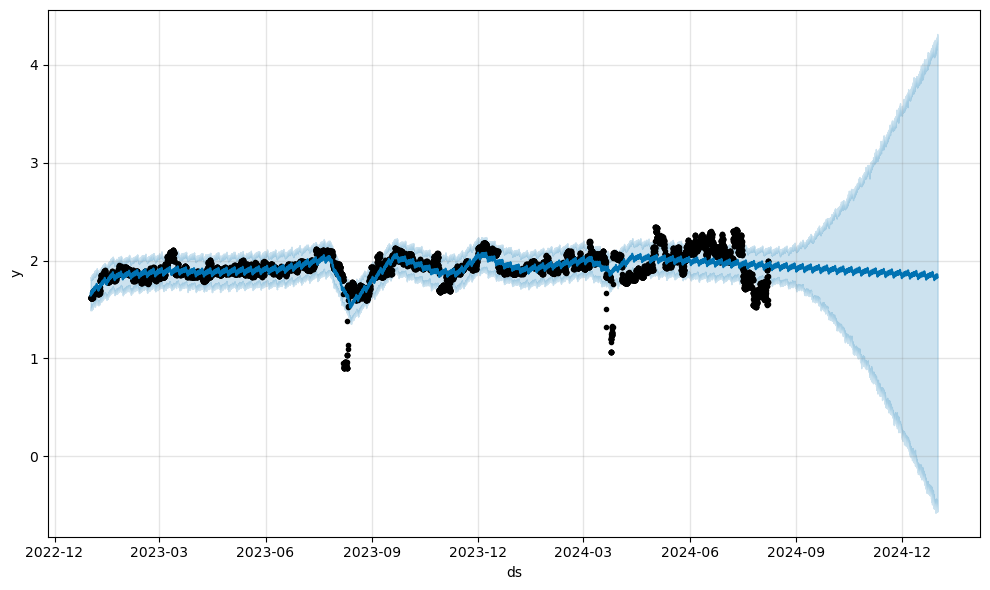

In [6]:
# Forecast
future = m.make_future_dataframe(periods=len(test), freq='H')
forecast = m.predict(future)

# Plot
fig = m.plot(forecast)
plt.show()

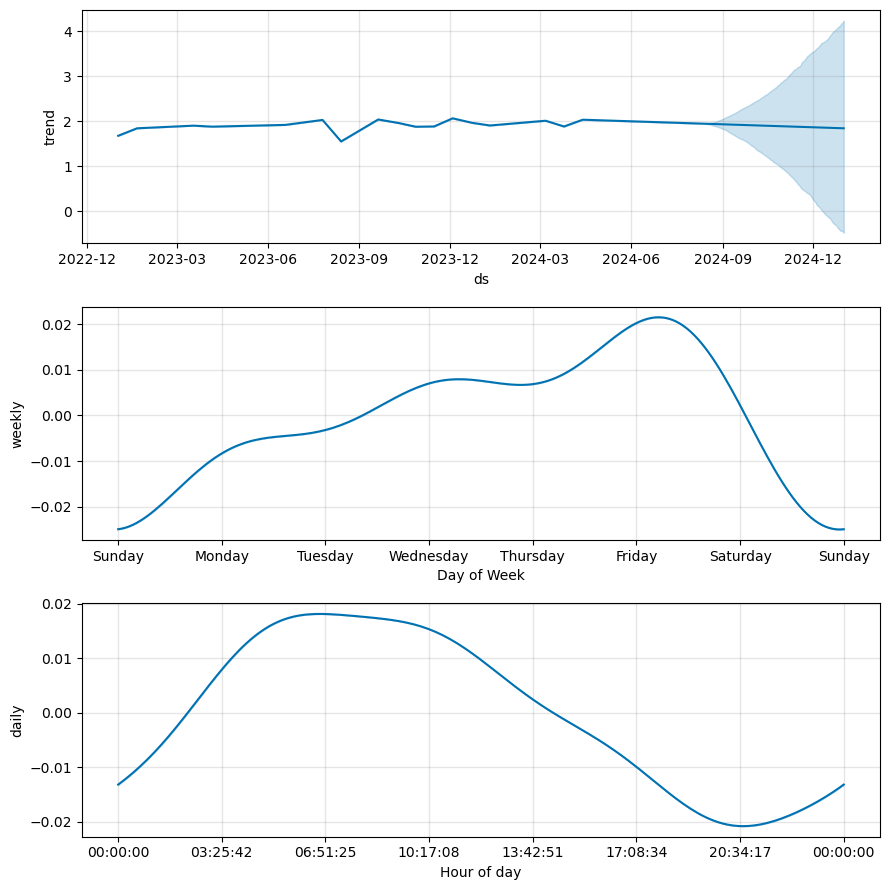

In [7]:
fig2 = m.plot_components(forecast)

In [8]:
# Error
y_true = frib['Watt Hours Received'][train_size:]
y_pred = forecast['yhat'][train_size:]
mape = mean_absolute_percentage_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)

print(f'Mean Absolute Percentage Error: {(mape*100):.3f}%')
print(f'Mean Squared Error: {mse}')

Mean Absolute Percentage Error: 9.956%
Mean Squared Error: 0.04690049731934162


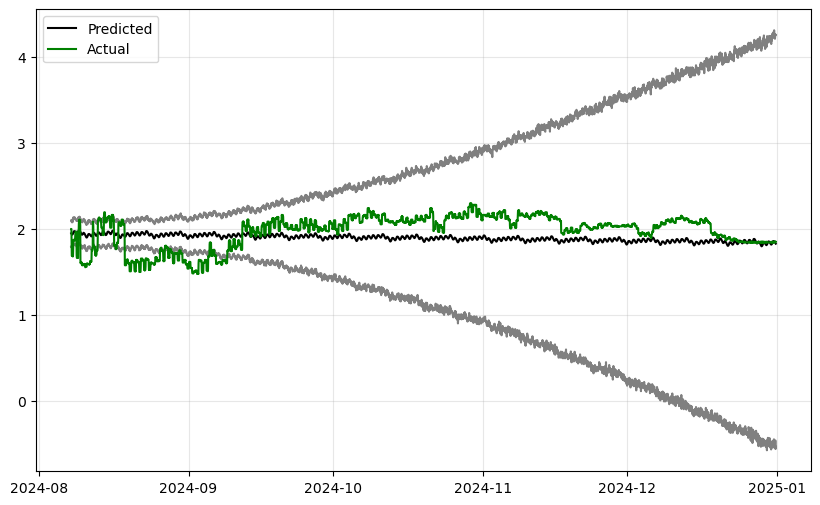

In [9]:
# Plot true and predicted values together
plt.figure(figsize=(10, 6))
plt.plot(frib['Timestamp'][train_size:], forecast['yhat'][train_size:], label='Predicted', color='black')
plt.plot(frib['Timestamp'][train_size:], forecast['yhat_upper'][train_size:], color='grey')
plt.plot(frib['Timestamp'][train_size:], forecast['yhat_lower'][train_size:], color='grey')
plt.plot(frib['Timestamp'][train_size:], frib['Watt Hours Received'][train_size:], label='Actual', color='green')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### Cross-Validation

09:38:17 - cmdstanpy - INFO - Chain [1] start processing
09:38:20 - cmdstanpy - INFO - Chain [1] done processing
09:38:24 - cmdstanpy - INFO - Chain [1] start processing
09:38:24 - cmdstanpy - INFO - Chain [1] start processing
09:38:24 - cmdstanpy - INFO - Chain [1] start processing
09:38:24 - cmdstanpy - INFO - Chain [1] start processing
09:38:24 - cmdstanpy - INFO - Chain [1] start processing
09:38:24 - cmdstanpy - INFO - Chain [1] start processing
09:38:24 - cmdstanpy - INFO - Chain [1] start processing
09:38:24 - cmdstanpy - INFO - Chain [1] start processing
09:38:30 - cmdstanpy - INFO - Chain [1] done processing
09:38:31 - cmdstanpy - INFO - Chain [1] start processing
09:38:31 - cmdstanpy - INFO - Chain [1] done processing
09:38:31 - cmdstanpy - INFO - Chain [1] done processing
09:38:31 - cmdstanpy - INFO - Chain [1] done processing
09:38:31 - cmdstanpy - INFO - Chain [1] start processing
09:38:31 - cmdstanpy - INFO - Chain [1] start processing
09:38:31 - cmdstanpy - INFO - Chain 

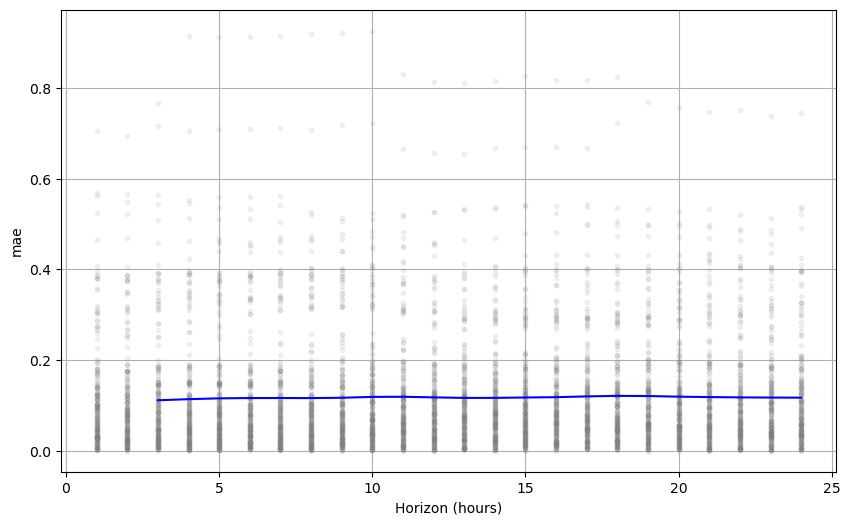

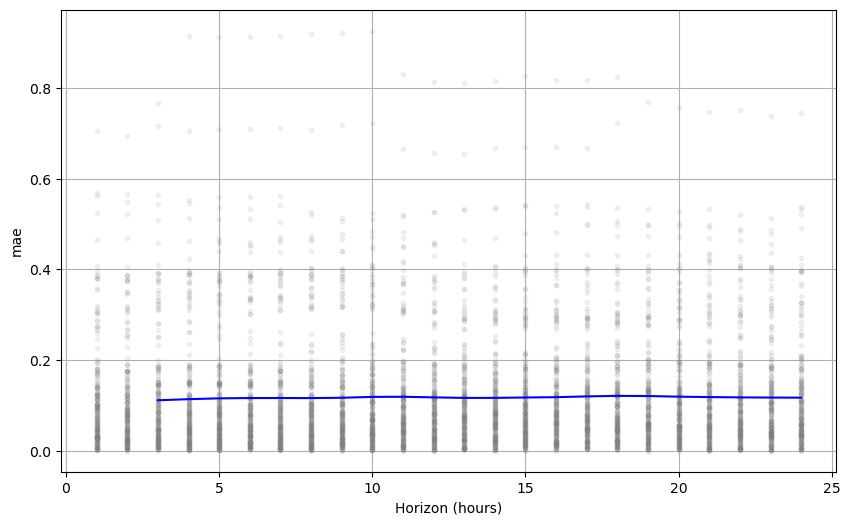

In [10]:
m = Prophet()
m.fit(frib_train)

# Cross-validation, looking at the last 365 days of data, for 24-hour periods, with a 24-hour horizon
df_cv = cross_validation(m, initial='365 days', period='24 hours', horizon='24 hours', parallel="processes")

# Performance metrics
df_p = performance_metrics(df_cv)

# Plot cross-validation performance metrics
from prophet.plot import plot_cross_validation_metric
plot_cross_validation_metric(df_cv, metric='mae')

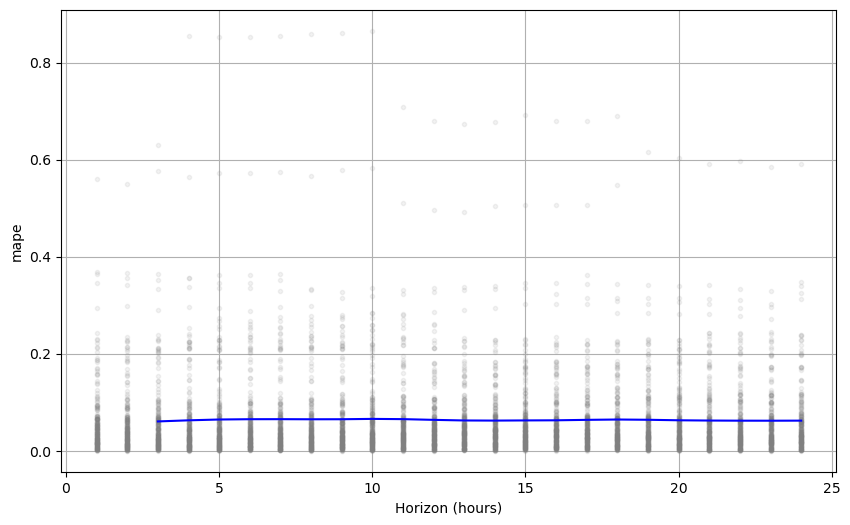

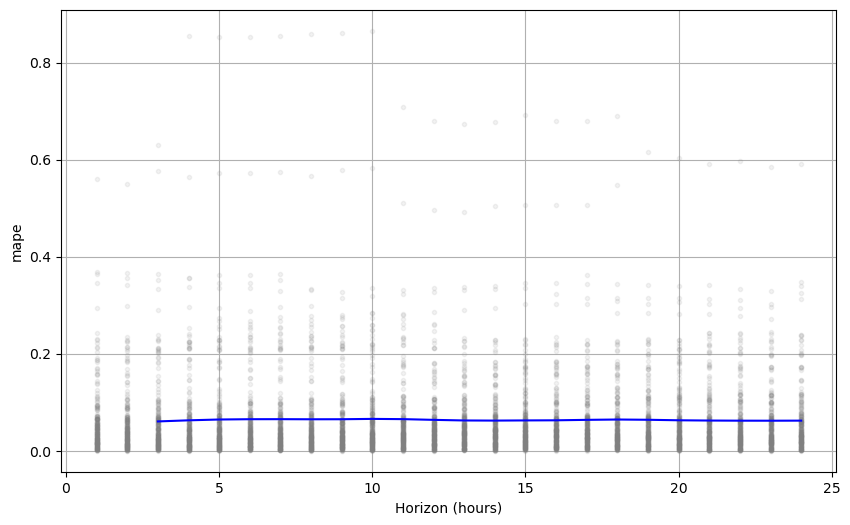

In [12]:
plot_cross_validation_metric(df_cv, metric='mape')

In [14]:
# Cross-validation, looking at the last 365 days of data, for 1 week periods, with a 1-week horizon
df_cv = cross_validation(m, initial='365 days', period='7 days', horizon='7 days', parallel="processes")

11:00:53 - cmdstanpy - INFO - Chain [1] start processing
11:00:53 - cmdstanpy - INFO - Chain [1] start processing
11:00:53 - cmdstanpy - INFO - Chain [1] start processing
11:00:53 - cmdstanpy - INFO - Chain [1] start processing
11:00:53 - cmdstanpy - INFO - Chain [1] start processing
11:00:53 - cmdstanpy - INFO - Chain [1] start processing
11:00:53 - cmdstanpy - INFO - Chain [1] start processing
11:00:53 - cmdstanpy - INFO - Chain [1] start processing
11:01:01 - cmdstanpy - INFO - Chain [1] done processing
11:01:01 - cmdstanpy - INFO - Chain [1] start processing
11:01:02 - cmdstanpy - INFO - Chain [1] done processing
11:01:03 - cmdstanpy - INFO - Chain [1] done processing
11:01:03 - cmdstanpy - INFO - Chain [1] done processing
11:01:03 - cmdstanpy - INFO - Chain [1] start processing
11:01:03 - cmdstanpy - INFO - Chain [1] start processing
11:01:03 - cmdstanpy - INFO - Chain [1] start processing
11:01:04 - cmdstanpy - INFO - Chain [1] done processing
11:01:04 - cmdstanpy - INFO - Chain 

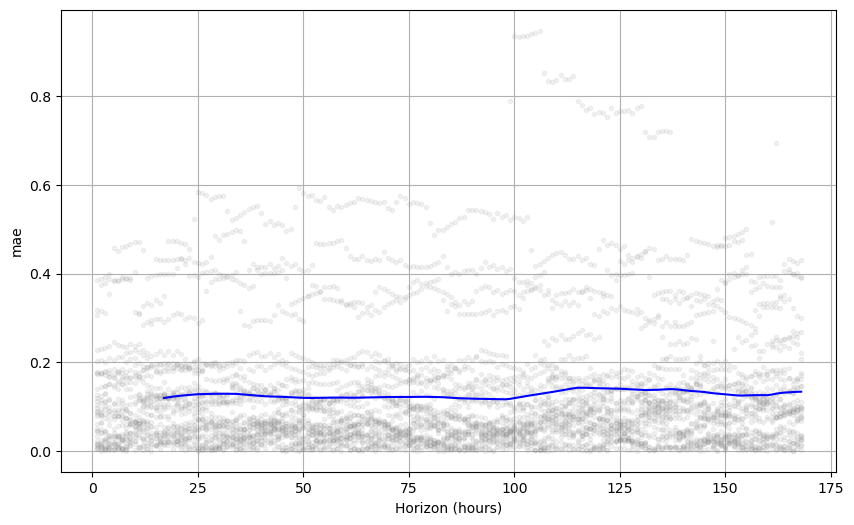

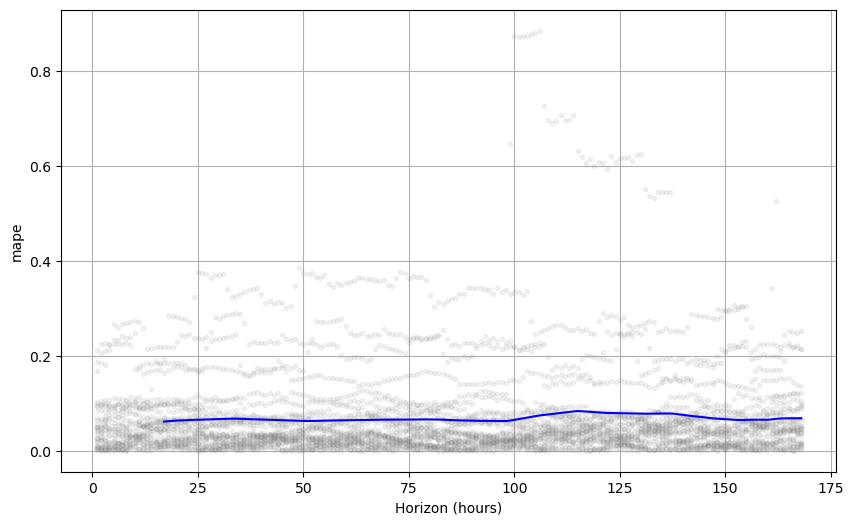

In [20]:
plot_cross_validation_metric(df_cv, metric='mae');
plot_cross_validation_metric(df_cv, metric='mape');

In [21]:
# Evaluate the model on the test set
df_test = pd.DataFrame()
df_test['ds'] = frib['Timestamp'][train_size:]
df_test['y'] = frib['Watt Hours Received'][train_size:]
df_test['yhat'] = forecast['yhat'][train_size:].values
df_test['yhat_upper'] = forecast['yhat_upper'][train_size:].values
df_test['yhat_lower'] = forecast['yhat_lower'][train_size:].values

# Calculate MAPE
mape = mean_absolute_percentage_error(df_test['y'], df_test['yhat'])
print(f'MAPE on test set: {mape:.3f}')

MAPE on test set: 0.100


Text(0.5, 1.0, 'Test Set Predictions')

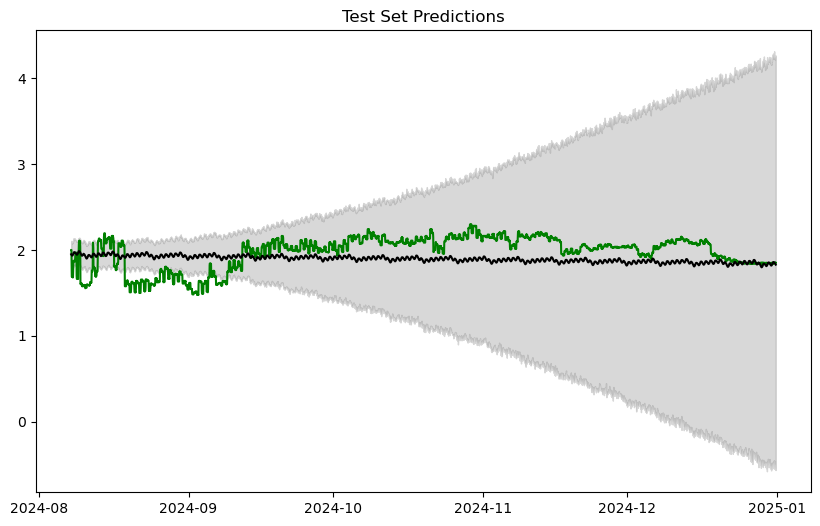

In [22]:
# Plot the test set predictions
plt.figure(figsize=(10, 6))
plt.plot(df_test['ds'], df_test['y'], label='Actual', color='green')
plt.plot(df_test['ds'], df_test['yhat'], label='Predicted', color='black')
plt.fill_between(df_test['ds'], df_test['yhat_lower'], df_test['yhat_upper'], color='grey', alpha=0.3)
plt.title('Test Set Predictions')

## Chem Data

In [23]:
# Load data
chem = pd.read_csv(FOLDER_PATH + '/Chem.csv')

# Calc Failed Mask
failed_mask = chem['Watt Hours Received'] == 'Calc Failed'
print(f'Found {failed_mask.sum()} Calc Failed values in Chem data')

Found 24 Calc Failed values in Chem data


In [24]:
# Convert to numeric
chem['Watt Hours Received'] = pd.to_numeric(chem['Watt Hours Received'], errors='coerce')

# Check for missing values
na_mask = chem['Watt Hours Received'].isna()
print(f'Found {na_mask.sum()} missing values in chem data')

# Drop NaN values
chem = chem.dropna(subset=['Watt Hours Received'])

# Remove cumulative values
chem['Watt Hours Received'] = chem['Watt Hours Received'].diff()

# Drop the first row
chem = chem.dropna()

# Convert to datetime
chem['Timestamp'] = pd.to_datetime(chem['Timestamp'])

Found 24 missing values in chem data


In [25]:
# Train test split
train_size = int(len(chem) * 0.8)
train, test = chem['Watt Hours Received'][:train_size].values.tolist(), chem['Watt Hours Received'][train_size:].values.tolist()

m = Prophet()
chem_train = pd.DataFrame()
chem_train['ds'] = chem['Timestamp'][:train_size]
chem_train['y'] = train
m.fit(chem_train)

11:10:08 - cmdstanpy - INFO - Chain [1] start processing
11:10:10 - cmdstanpy - INFO - Chain [1] done processing


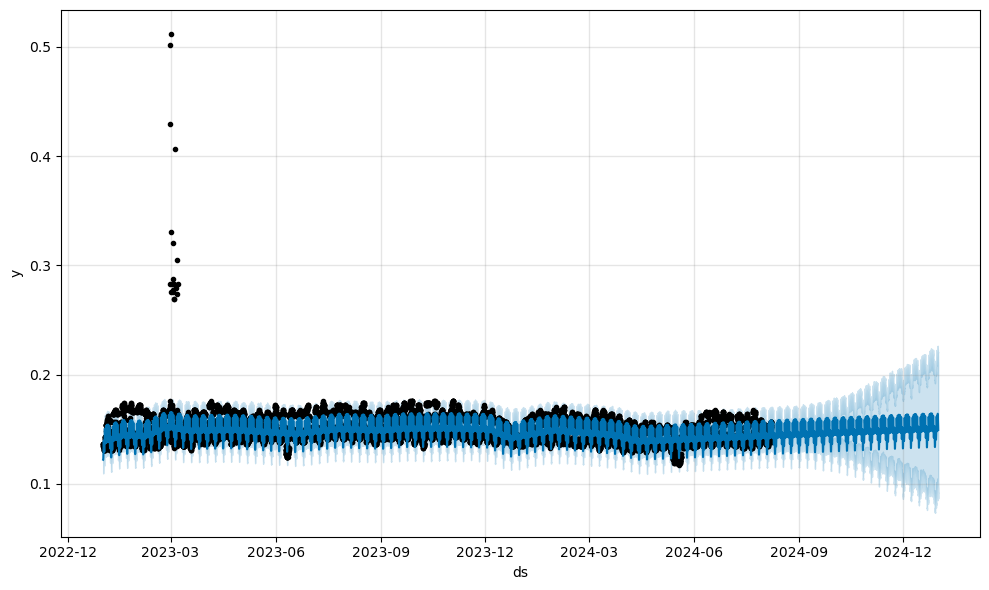

In [26]:
# Forecast
future = m.make_future_dataframe(periods=len(test), freq='H')
forecast = m.predict(future)

# Plot
fig = m.plot(forecast)
plt.show()

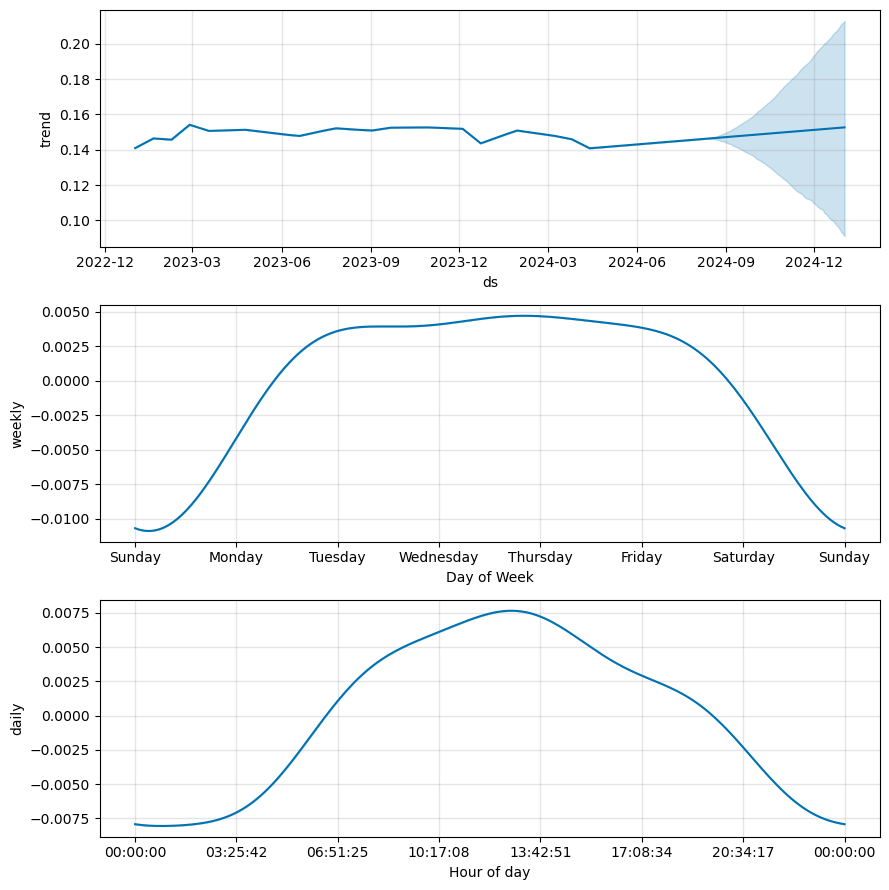

In [27]:
fig2 = m.plot_components(forecast)

In [28]:
# Error
y_true = chem['Watt Hours Received'][train_size:]
y_pred = forecast['yhat'][train_size:]

mape = mean_absolute_percentage_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)

print(f'Mean Absolute Percentage Error: {(mape*100):.3f}%')
print(f'Mean Squared Error: {mse}')

Mean Absolute Percentage Error: 3.563%
Mean Squared Error: 4.507728805940095e-05


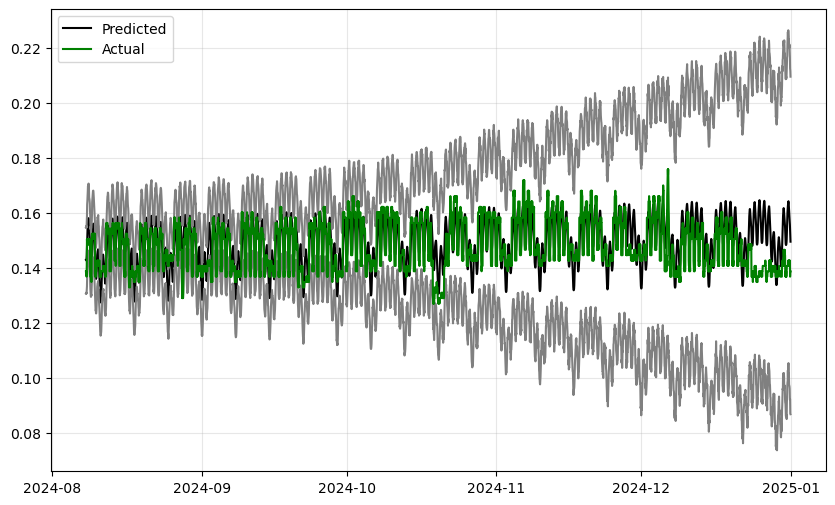

In [29]:
# Plot true and predicted values together
plt.figure(figsize=(10, 6))
plt.plot(chem['Timestamp'][train_size:], forecast['yhat'][train_size:], label='Predicted', color='black')
plt.plot(chem['Timestamp'][train_size:], forecast['yhat_upper'][train_size:], color='grey')
plt.plot(chem['Timestamp'][train_size:], forecast['yhat_lower'][train_size:], color='grey')
plt.plot(chem['Timestamp'][train_size:], chem['Watt Hours Received'][train_size:], label='Actual', color='green')
# plt.ylim((chem['Watt Hours Received'].min(), 0.2))
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [30]:
# Cross-validation, looking at the last 365 days of data, for 24-hour periods, with a 24-hour horizon
m = Prophet()
m.fit(chem_train)

df_cv = cross_validation(m, initial='365 days', period='24 hours', horizon='24 hours', parallel="processes");

11:10:34 - cmdstanpy - INFO - Chain [1] start processing
11:10:36 - cmdstanpy - INFO - Chain [1] done processing
11:10:40 - cmdstanpy - INFO - Chain [1] start processing
11:10:40 - cmdstanpy - INFO - Chain [1] start processing
11:10:40 - cmdstanpy - INFO - Chain [1] start processing
11:10:40 - cmdstanpy - INFO - Chain [1] start processing
11:10:40 - cmdstanpy - INFO - Chain [1] start processing
11:10:40 - cmdstanpy - INFO - Chain [1] start processing
11:10:40 - cmdstanpy - INFO - Chain [1] start processing
11:10:40 - cmdstanpy - INFO - Chain [1] start processing
11:10:46 - cmdstanpy - INFO - Chain [1] done processing
11:10:47 - cmdstanpy - INFO - Chain [1] start processing
11:10:47 - cmdstanpy - INFO - Chain [1] done processing
11:10:47 - cmdstanpy - INFO - Chain [1] done processing
11:10:48 - cmdstanpy - INFO - Chain [1] done processing
11:10:48 - cmdstanpy - INFO - Chain [1] start processing
11:10:48 - cmdstanpy - INFO - Chain [1] done processing
11:10:48 - cmdstanpy - INFO - Chain [

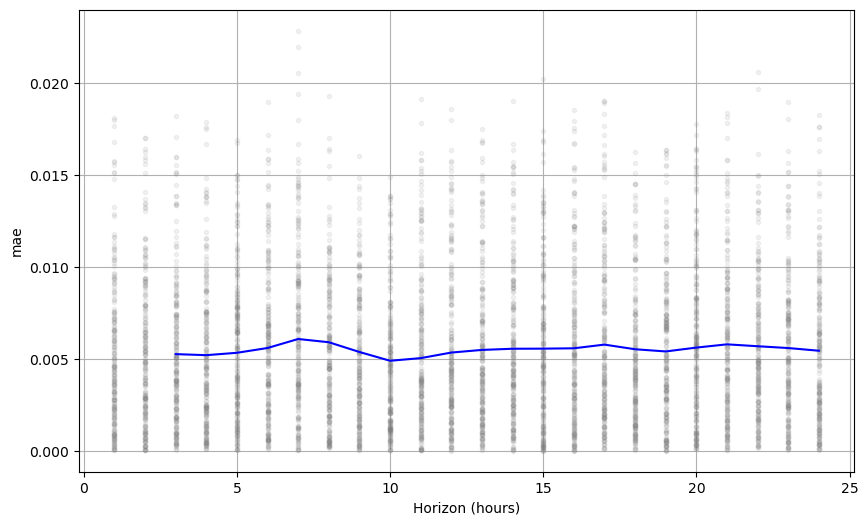

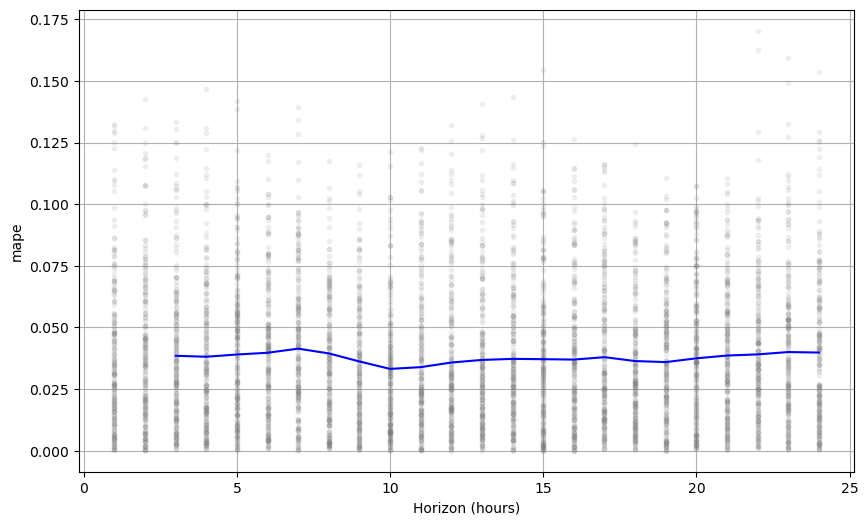

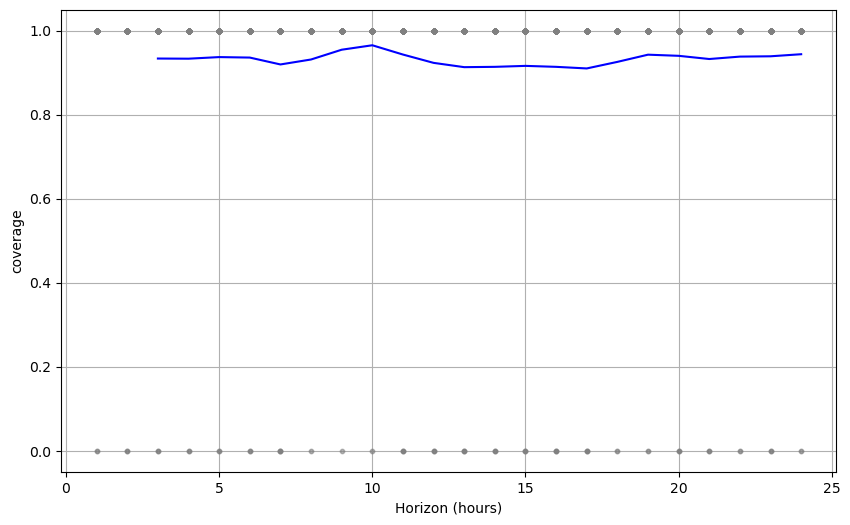

In [31]:
# Performance metrics
df_p = performance_metrics(df_cv)

# Plot cross-validation performance metrics
plot_cross_validation_metric(df_cv, metric='mae');
plot_cross_validation_metric(df_cv, metric='mape');
plot_cross_validation_metric(df_cv, metric='coverage');

In [32]:
# Cross-validation, looking at the last 365 days of data, for 1 week periods, with a 1-week horizon
df_cv = cross_validation(m, initial='365 days', period='7 days', horizon='7 days', parallel="processes");

11:14:40 - cmdstanpy - INFO - Chain [1] start processing
11:14:40 - cmdstanpy - INFO - Chain [1] start processing
11:14:40 - cmdstanpy - INFO - Chain [1] start processing
11:14:40 - cmdstanpy - INFO - Chain [1] start processing
11:14:40 - cmdstanpy - INFO - Chain [1] start processing
11:14:40 - cmdstanpy - INFO - Chain [1] start processing
11:14:40 - cmdstanpy - INFO - Chain [1] start processing
11:14:40 - cmdstanpy - INFO - Chain [1] start processing
11:14:44 - cmdstanpy - INFO - Chain [1] done processing
11:14:44 - cmdstanpy - INFO - Chain [1] start processing
11:14:46 - cmdstanpy - INFO - Chain [1] done processing
11:14:46 - cmdstanpy - INFO - Chain [1] done processing
11:14:46 - cmdstanpy - INFO - Chain [1] start processing
11:14:47 - cmdstanpy - INFO - Chain [1] done processing
11:14:47 - cmdstanpy - INFO - Chain [1] start processing
11:14:47 - cmdstanpy - INFO - Chain [1] start processing
11:14:47 - cmdstanpy - INFO - Chain [1] done processing
11:14:48 - cmdstanpy - INFO - Chain 

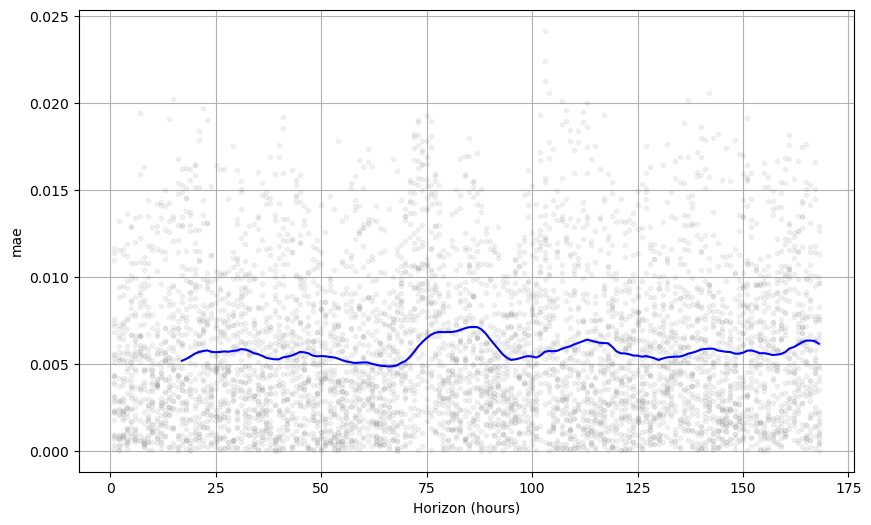

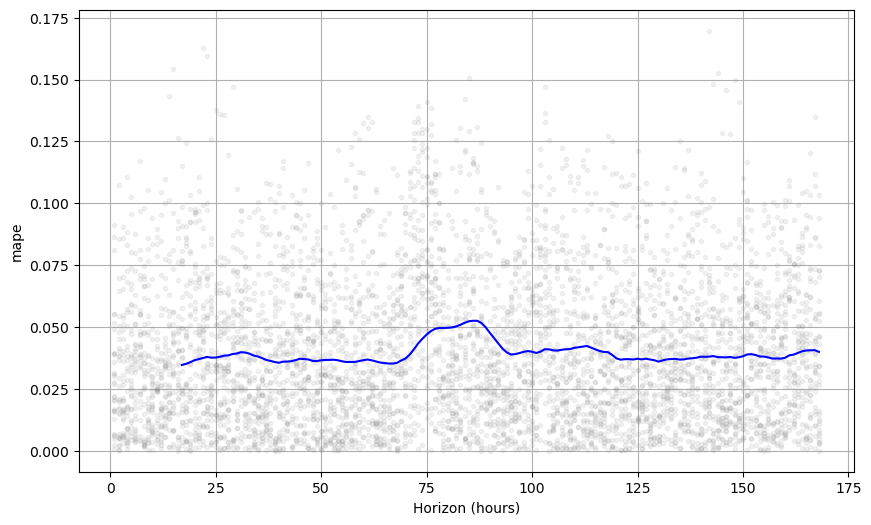

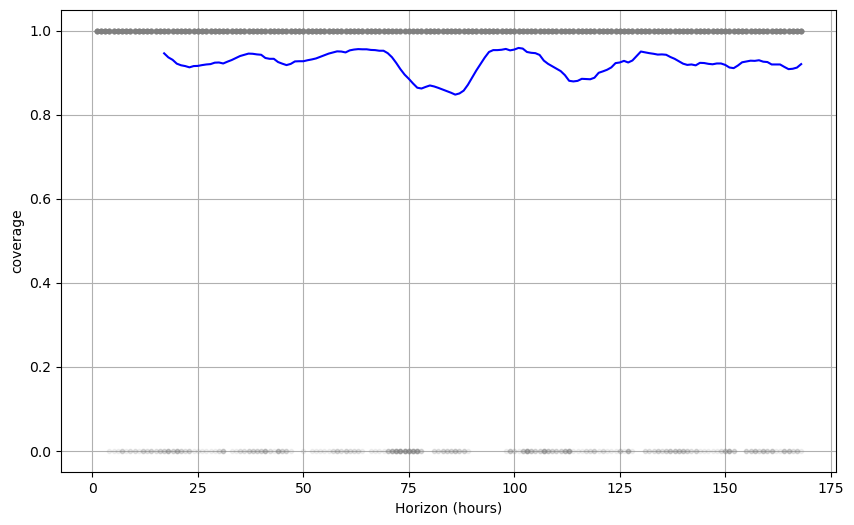

In [33]:
# Plot cross-validation performance metrics
plot_cross_validation_metric(df_cv, metric='mae');
plot_cross_validation_metric(df_cv, metric='mape');
plot_cross_validation_metric(df_cv, metric='coverage');

## Plant and Soil Sciences

In [28]:
pss = pd.read_csv(FOLDER_PATH + '/PSS.csv')

# Calc Failed Mask
failed_mask = pss['Watt Hours Received'] == 'Calc Failed'
print(f'Found {failed_mask.sum()} Calc Failed values in eng data')

Found 4 Calc Failed values in eng data


In [29]:
# Convert to numeric
pss['Watt Hours Received'] = pd.to_numeric(pss['Watt Hours Received'], errors='coerce')

# Check for missing values
na_mask = pss['Watt Hours Received'].isna()
print(f'Found {na_mask.sum()} missing values in pss data')

# Drop NaN values
pss = pss.dropna(subset=['Watt Hours Received'])

# Remove cumulative values
pss['Watt Hours Received'] = pss['Watt Hours Received'].diff()

# Drop the first row
pss = pss.dropna()

# Convert to datetime
pss['Timestamp'] = pd.to_datetime(pss['Timestamp'])

Found 4 missing values in pss data


In [30]:
# Train test split
train_size = int(len(pss) * 0.8)
train, test = pss['Watt Hours Received'][:train_size].values.tolist(), pss['Watt Hours Received'][train_size:].values.tolist()

m = Prophet()
pss_train = pd.DataFrame()
pss_train['ds'] = pss['Timestamp'][:train_size]
pss_train['y'] = train
m.fit(pss_train)

14:22:08 - cmdstanpy - INFO - Chain [1] start processing
14:22:12 - cmdstanpy - INFO - Chain [1] done processing


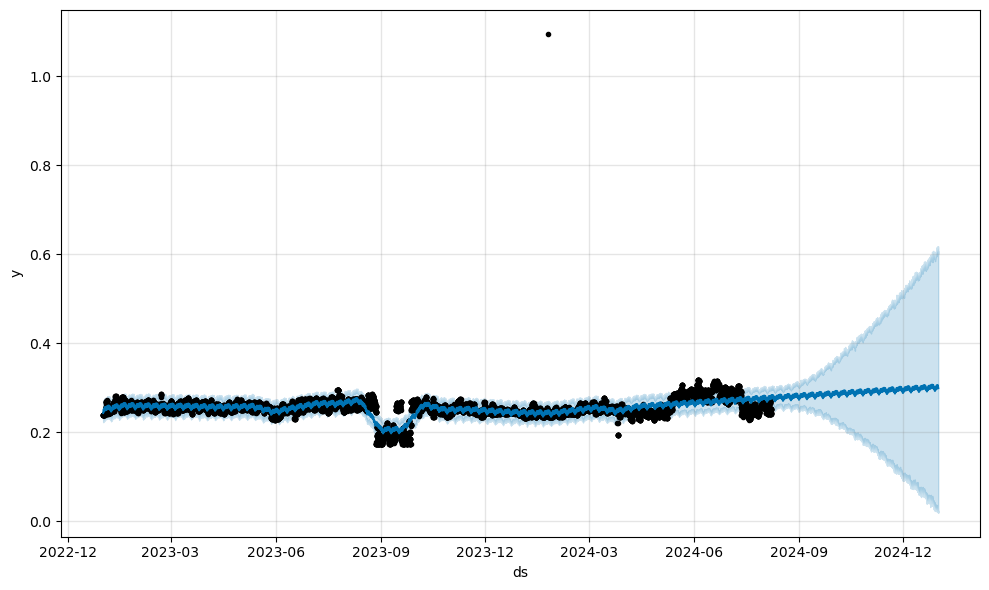

In [31]:
# Forecast
future = m.make_future_dataframe(periods=len(test), freq='H')
forecast = m.predict(future)

# Plot
fig = m.plot(forecast)
plt.show()

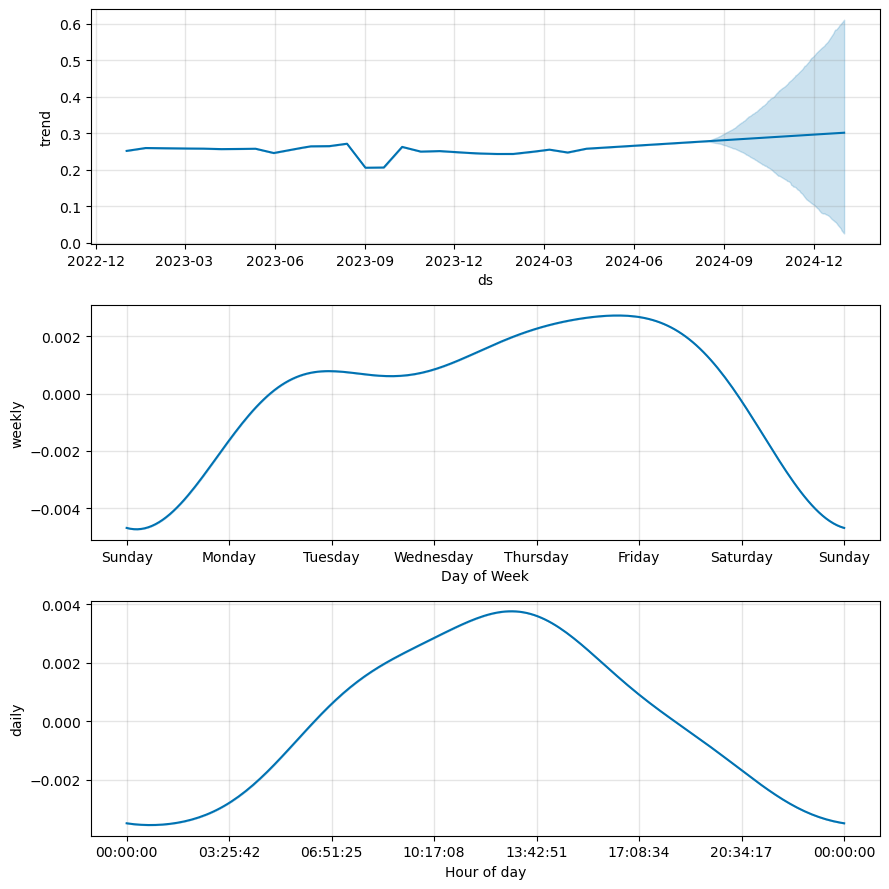

In [32]:
fig2 = m.plot_components(forecast)

In [33]:
# Error
y_true = pss['Watt Hours Received'][train_size:]
y_pred = forecast['yhat'][train_size:]

mape = mean_absolute_percentage_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)

print(f'Mean Absolute Percentage Error: {(mape*100):.3f}%')
print(f'Mean Squared Error: {mse}')

Mean Absolute Percentage Error: 23.722%
Mean Squared Error: 0.003586638805296419


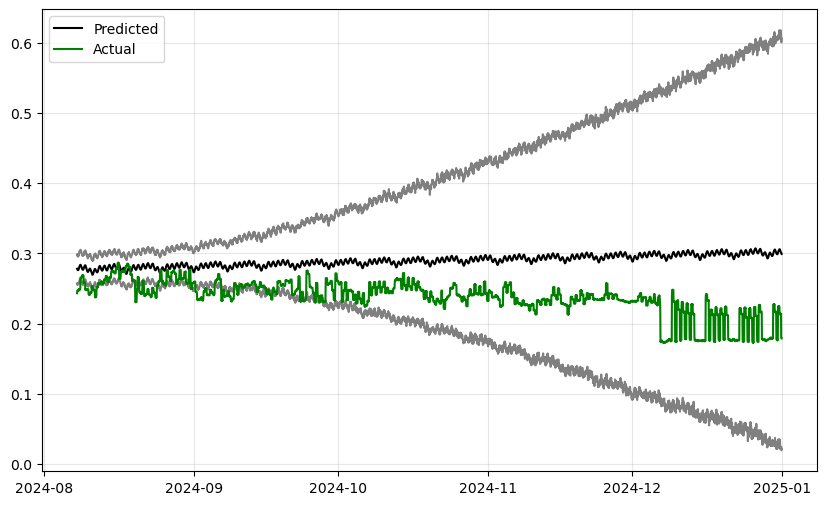

In [34]:
# Plot true and predicted values together
plt.figure(figsize=(10, 6))
plt.plot(pss['Timestamp'][train_size:], forecast['yhat'][train_size:], label='Predicted', color='black')
plt.plot(pss['Timestamp'][train_size:], forecast['yhat_upper'][train_size:], color='grey')
plt.plot(pss['Timestamp'][train_size:], forecast['yhat_lower'][train_size:], color='grey')
plt.plot(pss['Timestamp'][train_size:], pss['Watt Hours Received'][train_size:], label='Actual', color='green')
# plt.ylim((chem['Watt Hours Received'].min(), 0.2))
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [44]:
# Load data
bps = pd.read_csv(FOLDER_PATH + '/BPS.csv')

# Check for missing values
na_mask = bps['Watt Hours Received'].isna()
print(f'Found {na_mask.sum()} missing values in bps data')

# Remove cumulative values
bps['Watt Hours Received'] = bps['Watt Hours Received'].diff()

# Drop the first row
bps = bps.dropna()

Found 0 missing values in bps data


In [45]:
# Convert to datetime
bps['Timestamp'] = pd.to_datetime(bps['Timestamp'])

In [46]:
# Train test split
train_size = int(len(bps) * 0.8)
train, test = bps['Watt Hours Received'][:train_size].values.tolist(), bps['Watt Hours Received'][train_size:].values.tolist()

m = Prophet()
bps_train = pd.DataFrame()
bps_train['ds'] = bps['Timestamp'][:train_size]
bps_train['y'] = train
m.fit(bps_train)

14:26:15 - cmdstanpy - INFO - Chain [1] start processing
14:26:16 - cmdstanpy - INFO - Chain [1] done processing


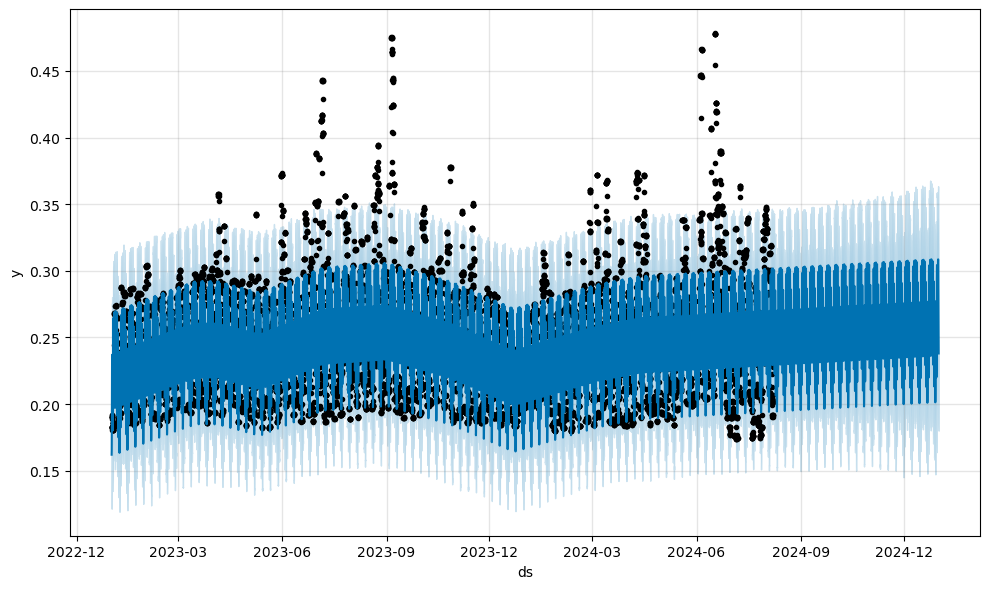

In [47]:
# Forecast
future = m.make_future_dataframe(periods=len(test), freq='H')
forecast = m.predict(future)

# Plot
fig = m.plot(forecast)
plt.show()

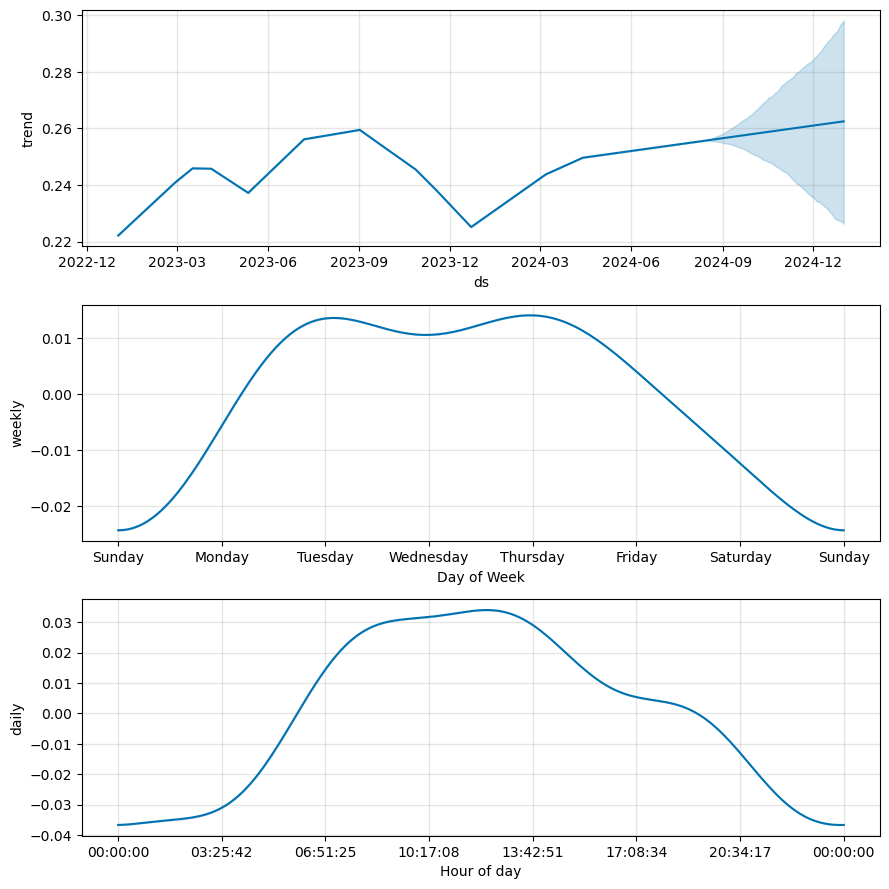

In [48]:
fig2 = m.plot_components(forecast)

In [49]:
# Error
y_true = bps['Watt Hours Received'][train_size:]
y_pred = forecast['yhat'][train_size:]

mape = mean_absolute_percentage_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)

print(f'Mean Absolute Percentage Error: {(mape*100):.3f}%')
print(f'Mean Squared Error: {mse}')

Mean Absolute Percentage Error: 19.380%
Mean Squared Error: 0.002261296923765274


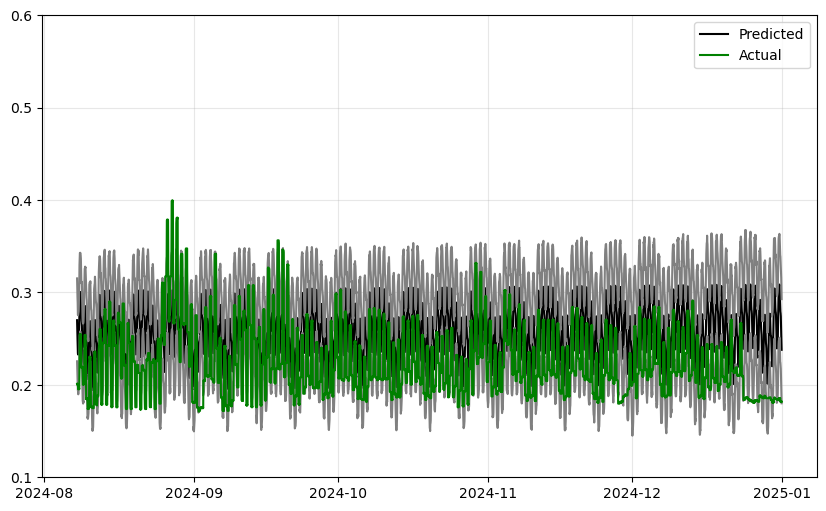

In [51]:
# Plot true and predicted values together
plt.figure(figsize=(10, 6))
plt.plot(bps['Timestamp'][train_size:], forecast['yhat'][train_size:], label='Predicted', color='black')
plt.plot(bps['Timestamp'][train_size:], forecast['yhat_upper'][train_size:], color='grey')
plt.plot(bps['Timestamp'][train_size:], forecast['yhat_lower'][train_size:], color='grey')
plt.plot(bps['Timestamp'][train_size:], bps['Watt Hours Received'][train_size:], label='Actual', color='green')
plt.ylim((0.1, 0.6))
plt.legend()
plt.grid(alpha=0.3)
plt.show()